In [4]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.formula.api as sm

from tqdm import tqdm

import scipy.io as sio
# for my supacool dark theme:
plt.style.use('dark_background')

## Real data

In [6]:
path2data= ''
'''A_raw = pd.readcsv(path2data + )
x_raw =prd.readcsv(path2data + )
y_raw =prd.readcsv(path2data + )'''

maf = sio.loadmat('GD/chr22_maf.mat')['maf']
maf

array([[ 0.01417329,  0.26962682,  0.27663048, ...,  0.36665057,
         0.12281923,  0.13698795]])

In [461]:
maf.shape

(1, 8915)

## Simulated data

In [306]:
# simul_data:
# return a random sample of  coefficients with s 
## Input: n, p, eventually a MAF (Minor Allel Frequency) vector 
## output A, the genotype matrix
def simul_data(n, p=500, maf=None, miss = 0., miss_value='average'):
    '''
    Simulate the matrix A
    '''
    A = []
    if maf is None:
        maf = np.random.uniform(low=0.1, high=0.5, size = (1, p))
    else:
        for idx, i in enumerate(maf[0]):
            if i < 0.01:
                maf[0][idx] = 0.01
    for _ in range(n):
        A.append(np.random.binomial(2, maf)[0])
    A = np.array(A)
    # st = A.std(axis=0)
    # m = A.mean(axis=0)
    # print(2*maf)
    # print(1-maf)
    A = (A-2*maf)/(2*maf*(1-maf))/np.sqrt(n)
    
    return A

# With MAF    
# B = simul_data(5000, p=10)

In [307]:
# B.shape

In [308]:
'''# Simulate Phenotype y given a genotype matrix A
Input:  A, genotype matrix (either real or simulated data)
        s, sparsity of the x vector (number of non zeros coeffs)
        h2, heritability (ratio of the phenotype explained by the genotype)
        xtype, in ['uniform', 'hyperExp'(not coded yet)], type of coefficients simulated 
'''
def genPhenotype(A, s, h2 = 1., xtype = 'uniform'):
    
    assert xtype in ['uniform', 'hyperExp'], 'Error, xtype should be "uniform" or "hyperExps"'
    
    n = A.shape[0]
    p = A.shape[1]
    x = np.random.uniform(-1,1,p)
    
    if xtype == 'hyperExp':
        x = np.exp(-(np.arange(p) + 1) / (.05*s)) + np.exp(-(np.arange(p)+1)/p)
    # set s coefficients to zeros
    x_mask = np.random.choice(np.arange(p), p-s, replace= False)
    x[x_mask] = 0
    # heritability
    if h2<1.:
        x = np.sqrt(h2) * x / np.std(A.dot(x))
        e = np.sqrt(1.-h2) * np.random.normal(n)
        y = A.dot(x) + e
        return x, y, e
    else:
        x = x/np.std(A.dot(x))
        return x, A.dot(x), 0
#genPhenotype(At, st)

In [ ]:
At = simul_data(100, 10, maf=maf)
x, y, e = genPhenotype(A, 10)

## Recovery algorithm: Linear regression with Lasso

We solve the following minimisation problem using scikit-learn : 
$$min_x [\Vert y -Ax \Vert_{L_2}^2+\lambda \Vert x \Vert_{L_1}]$$

In [246]:
def lasso(A, y, lambd = 0.1, normalize = True):
    """return the coefficient of the lasso regression of A over y, lambd is the regulizer parameter
    """
    reg = linear_model.Lasso(lambd*np.sqrt(A.shape[0]), normalize = normalize)
    reg.fit(A, y)
    return reg.coef_

In [577]:
def iterativeLasso(A, y, nb_lambd=100, normalize=True, verbose=False):
    """implement the iterative lasso with the same regularization path as in the paper"""
    n = A.shape[0]
    lambd_max = np.linalg.norm(y.dot(A), ord = np.inf)/n
    e = np.random.normal(size=(1000, n))
    Ae_inf = [np.linalg.norm(v, ord = np.inf) for v in e.dot(A)]
    var_e_corrected = np.sqrt(1 + 1/n)
    lambd_min = np.median(Ae_inf) * var_e_corrected/n
    alphas = np.linspace(lambd_min, lambd_max, nb_lambd)/(n)
    #print(alphas)
    reg = linear_model.LassoCV(alphas=alphas, normalize=normalize)
    reg.fit(A, y)
    # print(reg.alpha_)
    return reg.coef_, reg.alpha_

## Recovery measures:

We implemented the different recovery measures developped in the paper:

* **PPV**, Positive Predicted Value: the ratio between the number of True Positive and the number of selected Positive coefficients (i.e. the number of non-zero coefficients: $\frac{\#\{x_i : x_i\neq 0;\hat x_i \neq 0\}}{\#\{\hat x_i:\hat x_i \neq 0\}}$

* **FPR**, False Positive Rate: the ratio between the number of False Positive and the total number of Negative coefficients (i.e. the number of zero coefficients): $\frac{\#\{x_i : x_i = 0;\hat x_i \neq 0\}}{\#\{x_i:x_i = 0\}}$ 

* **$med_{P-val}$**, the median of the P-values obtained when regressing the phenotypes on each selected SNP. For each of this regression, we compute the p-value associated to the t-test asserting if the coefficient of the regression is zero. We then take the median of these p-values. Note that, contrary to the other measures of recovery, this one could be computed in real experiments where we don't have access to the true coefficients x.

In [578]:
# positive predictive value
def PPV(x, x_hat):
    nb_tp = np.sum([1 for u,v in zip(x, x_hat) if (u != 0) and (v != 0)])
    nb_pos = np.sum([1 for e in x_hat if e!=0])
    assert nb_pos !=0, 'mError, x is null!'
    return nb_tp/nb_pos

def FPR(x, x_hat):
    nb_fp = np.sum([1 for u,v in zip(x, x_hat) if (u==0) and (v!=0)])
    nb_neg = np.sum([1 for e in x if e==0])
    if nb_neg ==0:
        print('FPR computation Warning, x is not sparse!')
        return -1
    return nb_fp/nb_neg

def med_P(x_hat, y, A, verbose = False):
    p_vals = []
    for i in np.arange(len(y)):
        if x_hat[i] != 0:
            snp = A[:,i]
            reg = sm.OLS(y, snp).fit()
            p_vals.append(reg.t_test([1]).pvalue) 
    measure = np.median(np.array(p_vals))
    if verbose:
        print('{} selected non zero coefficients (over {} total number of SNPs)'.format(len(p_vals), len(x_hat)))
    return measure

## Phase-transition 

In [579]:
# for the simulated assays
def phase_transition_mat(A, lambd = 0.1, h2 = 1, xtype = 'uniform', size = 20, recovery = False):
    """return return a size by size matrix with the NE score for the lasso reconstruction procedure 
    A : measurement matrix (genotype)
    h2: heritability (control the )
    size : the size of the phase transition matrix
    """
    # number of samples
    n = A.shape[0]
    # number of SNPs
    p = A.shape[1]
    # In order to test all values for delta, we need to have enough data
    assert n==p, "ERROR, n must be equal to p"
    
    PTM = np.zeros((size, size))
    ix = np.arange(n)
    lambdas = []
    
    if recovery:
        PPV_mat = np.zeros((size, size))
        FPR_mat = np.zeros((size, size))
        medP_mat = np.zeros((size, size))
    for i in tqdm(range(size)):

        for j in range(size):
            rho = (i+1)/size
            delta = (j+1)/size
            
            n_tmp = int(p*delta)
            s = int(rho*n_tmp)

            ix_tmp = np.random.choice(ix, n_tmp, replace=False)
            A_tmp = A[ix_tmp][:]
            x, y, e = genPhenotype(A=A_tmp, s=s, h2=1.) 
            # x_pred = lasso(A_tmp, y, lambd = lambd)
            x_pred, la = iterativeLasso(A_tmp, y, nb_lambd=100, normalize=True, verbose=False)
            lambdas.append(la)
            norm = np.linalg.norm(x-x_pred)/np.linalg.norm(x)
            # big errors (>1) are marked as 1.
            PTM[i, j] = min([norm, 1.])
            
            if recovery:
                PPV_mat[i, j] = PPV(x, x_pred)
                FPR_mat[i, j] = FPR(x, x_pred)
                medP_mat[i, j] = med_P(x_pred, y, A)
                
                
    return PTM, lambdas

In [587]:
# test purpose
nt = 500
pt = 500
At = simul_data(n = nt, p = pt)

# At = simul_data(n = nt, maf=maf[:][:200])

In [588]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [ ]:
PTM2, x_store, x_store_pred = phase_transition_mat(At, lambd = 0.00005, h2 = 1., xtype = 'hyperExp', size=20, recovery= False)
# PTM[10]

  5%|▌         | 1/20 [00:04<01:19,  4.19s/it]

# Plot the matrix of transition

In [568]:
def frontier(mat, thres, size):
    """construction of the phase transition frontier, i.e. first time the NE score is below the thres value"""
    L = []
    N = len(mat)
    for s in range(int(N)):
        P = 0
        while mat[P,s]<thres and P<N-1:
            P = P + 1
        L.append(P/size)
    return L

In [569]:
def plot_transition(M, thres = 0.5, save = False):
    size = M.shape[0]
    #plt.figure(figsize=(8,8))
    #rho_min, rho_max, delta_min, delta_max = 0, size, 0, size
    fig = plt.imshow(M, interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent = [0., 1., 0., 1.])
    plt.xlabel(r'$\delta = \frac{n}{p}$')
    plt.ylabel(r'$\rho = \frac{s}{n}$')

    #empirical phase transition
    X = np.arange(0., 1., 1./size)
    L = frontier(M, thres = thres, size=size)
    plt.plot(X,L, linewidth=4, color = 'black', label='phase transition')
    plt.legend(loc=1)
    cax = plt.axes([1, 0.1, 0.075, 0.8])
    plt.colorbar(cax=cax)
    
    if save == True:
        filename = 'transition_matrix.png'
        plt.savefig(filename,bbox_inches='tight')
    plt.show()

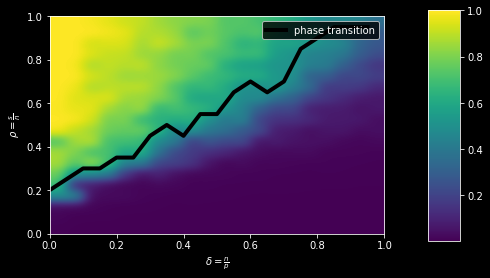

In [572]:
plot_transition(PTM, save=True)

In [345]:
x_store

array([[   5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,   45.,
          50.],
       [  10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
         100.],
       [  15.,   30.,   45.,   60.,   75.,   90.,  105.,  120.,  135.,
         150.],
       [  20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.,
         200.],
       [  25.,   50.,   75.,  100.,  125.,  150.,  175.,  200.,  225.,
         250.],
       [  30.,   60.,   90.,  120.,  150.,  180.,  210.,  240.,  270.,
         300.],
       [  35.,   70.,  105.,  140.,  175.,  210.,  245.,  280.,  315.,
         350.],
       [  40.,   80.,  120.,  160.,  200.,  240.,  280.,  320.,  360.,
         400.],
       [  45.,   90.,  135.,  180.,  225.,  270.,  315.,  360.,  405.,
         450.],
       [  50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,  450.,
         500.]])

In [346]:
x_store_pred

array([[   8.,   12.,   21.,   30.,   53.,   61.,  114.,   75.,  117.,
         169.],
       [  37.,   68.,  102.,  132.,  136.,  156.,  153.,  167.,  165.,
         173.],
       [  42.,   72.,  104.,  124.,  132.,  158.,  165.,  173.,  188.,
         182.],
       [  39.,   71.,  104.,  124.,  141.,  161.,  164.,  164.,  177.,
         179.],
       [  41.,   75.,  102.,  127.,  141.,  152.,  166.,  171.,  175.,
         173.],
       [  40.,   74.,  109.,  129.,  137.,  153.,  167.,  172.,  177.,
         181.],
       [  42.,   74.,  106.,  132.,  135.,  151.,  170.,  177.,  186.,
         180.],
       [  39.,   74.,  108.,  124.,  140.,  156.,  162.,  173.,  175.,
         179.],
       [  41.,   74.,  105.,  128.,  139.,  158.,  163.,  170.,  178.,
         184.],
       [  40.,   71.,  106.,  131.,  139.,  153.,  167.,  167.,  181.,
         187.]])

In [447]:
p = 1000
A = simul_data(n = p, p = p)

In [576]:
# s_step = n_tmp // size
# s_tmp = (i+1) * s_step

rho = 0.3
delta = 0.1

n_tmp = int(p*delta)
s = int(rho*n_tmp)
# ix = np.arange(n)
#ix_tmp = np.random.choice(ix, n_tmp)

x, y, e = genPhenotype(A=A[:n_tmp][:], s=s, h2=1.) 

# x_pred = lasso(A[ix_tmp, :], y, lambd = lambd)
x_pred = iterativeLasso(A[:n_tmp][:], y, nb_lambd=100, normalize=True, verbose=False)

0.000243201830556


In [469]:
np.linalg.norm(x-x_pred)/np.linalg.norm(x)

0.49342572032238585